split data

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define dataset path
base_dir = r'D:\I3D\yashtidataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Create directories if they don’t exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate through class folders
classes = [cls for cls in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, cls)) and cls not in ['train', 'test']]

# Split each class
for cls in classes:
    cls_path = os.path.join(base_dir, cls)
    images = os.listdir(cls_path)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    # Make class subdirectories in train/test
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    # Copy files
    for img in train_images:
        shutil.copy(os.path.join(cls_path, img), os.path.join(train_dir, cls, img))

    for img in test_images:
        shutil.copy(os.path.join(cls_path, img), os.path.join(test_dir, cls, img))



In [ ]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
import time
import glob 

# --- 1. CONFIGURATION AND I3D IMPORT ---
# -----------------------------------------------------------------------------
# ⚠️ ACTION REQUIRED: Update this path to your cloned pytorch-i3d repository
I3D_REPO_PATH = 'D:\\I3D\\pytorch-i3d' 
sys.path.append(I3D_REPO_PATH)

try:
    # ⚠️ Adjust the module name ('i3d') and class ('InceptionI3d') if your repo differs
    from i3d import InceptionI3d
except ImportError as e:
    sys.stdout.write(f"CRITICAL ERROR: Could not import I3D model. Check I3D_REPO_PATH. Error: {e}\n")
    # Define a Mock Class to allow the rest of the code structure to be executed
    class InceptionI3d(nn.Module): 
        def __init__(self, num_classes=1000, in_channels=3):
            super().__init__()
            self.logits = nn.Linear(10, num_classes)
            sys.stdout.write("WARNING: Using Mock I3D Model.\n")
        def forward(self, x): 
            # Mock forward pass returns a result tensor of shape (Batch, Classes)
            return torch.randn(x.size(0), self.logits.out_features) 
        def replace_logits(self, num_classes):
            self.logits = nn.Linear(10, num_classes) # Mock replacement
            sys.stdout.write(f"Mock logits replaced for {num_classes} classes.\n")

# --- Paths and Hyperparameters ---
TRAIN_DATA_ROOT = 'D:\\I3D\\yashtidataset\\train'
TEST_DATA_ROOT = 'D:\\I3D\\yashtidataset\\test'
I3D_WEIGHTS = 'SRC/aug_data_i3d.pt' # Assuming this is the path relative to your notebook, or full path

CLIP_LENGTH = 16
CROP_SIZE = 224
BATCH_SIZE = 1
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20

# Environment Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sys.stdout.write(f"Using device: {device}\n")

# Determine the number of classes
try:
    class_names = sorted(os.listdir(TRAIN_DATA_ROOT))
    class_names = [d for d in class_names if os.path.isdir(os.path.join(TRAIN_DATA_ROOT, d))]
    NUM_CLASSES = len(class_names)
    sys.stdout.write(f"Detected {NUM_CLASSES} classes: {class_names}\n")
except FileNotFoundError:
    sys.stdout.write("Warning: Dataset root path not found. Setting NUM_CLASSES to 2.\n")
    NUM_CLASSES = 2 


# --- 2. CUSTOM PYTORCH VIDEO DATASET ---
# -----------------------------------------------------------------------------

class I3DVideoDataset(torch.utils.data.Dataset):
    """Loads video paths and handles dummy frame sampling/normalization for I3D structure."""
    def __init__(self, root_dir, clip_len=CLIP_LENGTH, crop_size=CROP_SIZE):
        self.root_dir = root_dir
        self.clip_len = clip_len
        self.crop_size = crop_size
        self.video_paths = []
        self.labels = []
        
        # Determine classes
        class_names_local = sorted(os.listdir(root_dir))
        class_names_local = [d for d in class_names_local if os.path.isdir(os.path.join(root_dir, d))]
        self.class_to_idx = {name: i for i, name in enumerate(class_names_local)}
        
        for class_name in class_names_local:
            class_dir = os.path.join(root_dir, class_name)
            for video_file in glob.glob(os.path.join(class_dir, '*.*')): 
                self.video_paths.append(video_file)
                self.labels.append(self.class_to_idx[class_name])
        
        # I3D standard mean/std (C, 1, 1, 1) for broadcasting
        self.mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32).view(3, 1, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32).view(3, 1, 1, 1)

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        
        try:
             # ⚠️ INTEGRATE YOUR I3D VIDEO LOADER HERE: 
             # Replace this with code that reads video, samples frames, and returns a 
             # tensor of shape (C, T, H, W) where values are [0, 1] or [0, 255].
             # Dummy tensor (C, T, H, W) with values [0, 1]:
             video_tensor = torch.rand(3, self.clip_len, self.crop_size, self.crop_size) 
             
             # Apply Normalization
             video_tensor = (video_tensor - self.mean) / self.std
             
        except Exception as e:
            # sys.stderr.write(f"Error loading video {video_path}: {e}\n")
            return None, None 

        return video_tensor, torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    # Filters out (None, None) samples from failed video loads
    batch = list(filter(lambda x: x[0] is not None, batch))
    if not batch:
        return torch.tensor([]), torch.tensor([]) 

    frames, labels = zip(*batch)
    return torch.stack(frames, 0), torch.stack(labels, 0)

# Create Datasets and DataLoaders
train_ds = I3DVideoDataset(TRAIN_DATA_ROOT)
test_ds = I3DVideoDataset(TEST_DATA_ROOT)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, collate_fn=collate_fn)

sys.stdout.write(f"Train DataLoader size: {len(train_loader)} batches\n")
sys.stdout.write(f"Test DataLoader size: {len(test_loader)} batches\n")


# --- 3. MODEL INITIALIZATION AND OPTIMIZER SETUP (WITH FIXES) ---
# -----------------------------------------------------------------------------

model = InceptionI3d(num_classes=400, in_channels=3) 

# Load Your Specific Pre-trained Weights (for fine-tuning)
try:
    weights = torch.load(I3D_WEIGHTS, map_location=device)
    model.load_state_dict(weights, strict=False) 
    sys.stdout.write(f"Successfully loaded I3D weights from {I3D_WEIGHTS}.\n")
except Exception as e:
    sys.stdout.write(f"Warning: Error loading I3D weights: {e}\n")
    
# Modify the final classification layer for the target number of classes
model.replace_logits(NUM_CLASSES)
model.to(device)
sys.stdout.write(f"I3D final layer adapted for {NUM_CLASSES} classes.\n")

# --- CRITICAL FIX: Ensure the new logits layer is trainable ---
# 1. Freeze all pre-trained layers first
for param in model.parameters():
    param.requires_grad = False
sys.stdout.write("All model parameters initially frozen.\n")
    
# 2. Explicitly UNFREEZE the new classification head
unfrozen_count = 0
head_layer_names = ['logits', 'fc', 'classifier'] 

for name, module in model.named_modules():
    # Only target final layer candidates that are Linear or Conv3d
    if any(head_name in name for head_name in head_layer_names) and isinstance(module, (nn.Linear, nn.Conv3d)):
        # Simple heuristic to unfreeze high-level modules
        if name.count('.') < 3: 
            for param in module.parameters():
                param.requires_grad = True
                unfrozen_count += 1
            sys.stdout.write(f"✅ Unfroze parameters in the final layer: {name}\n")

# Fallback: If no standard layer was found, assume the model is entirely new or requires training
if unfrozen_count == 0:
    for param in model.parameters():
        param.requires_grad = True
        unfrozen_count += 1
    sys.stdout.write("⚠️ WARNING: No specific head found. Unfreezing ALL parameters for training from scratch.\n")


# --- Loss and Optimizer ---
criterion = nn.CrossEntropyLoss()

# Initialize the optimizer with only the filtered list of trainable parameters.
trainable_params = [p for p in model.parameters() if p.requires_grad]

if not trainable_params:
    raise ValueError("FATAL ERROR: Found zero trainable parameters. Check model import.")

optimizer = optim.Adam(trainable_params, lr=LEARNING_RATE) 

sys.stdout.write(f"Optimizer successfully initialized with {len(trainable_params)} trainable parameters.\n")


# --- 4. TRAINING AND EVALUATION FUNCTIONS ---
# -----------------------------------------------------------------------------

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for inputs, labels in tqdm(dataloader, desc="Training"):
        if inputs.numel() == 0: continue 
            
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += labels.size(0)
        
    epoch_loss = total_loss / total_samples if total_samples > 0 else 0
    epoch_acc = correct_predictions.double() / total_samples if total_samples > 0 else 0
    return epoch_loss, epoch_acc.item()

def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            if inputs.numel() == 0: continue 
                
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples if total_samples > 0 else 0
    accuracy = accuracy_score(all_labels, all_preds) if total_samples > 0 else 0
    
    return avg_loss, accuracy, np.array(all_labels), np.array(all_preds)


# --- 5. MAIN TRAINING AND EVALUATION LOOP ---
# -----------------------------------------------------------------------------

sys.stdout.write("\nStarting Training...\n")

best_test_acc = 0.0
model_path = 'best_i3d_finetuned_model.pth'

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    
    # --- Train ---
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # --- Evaluate on Test Set ---
    test_loss, test_acc, _, _ = evaluate(model, test_loader, device)
    
    epoch_duration = time.time() - start_time
    
    # --- Print Results ---
    sys.stdout.write(f"Epoch {epoch+1}/{NUM_EPOCHS} - Time: {epoch_duration:.2f}s\n")
    sys.stdout.write(f"  [TRAIN] Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}\n")
    sys.stdout.write(f"  [TEST]  Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}\n")
    
    # --- Save Best Model ---
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), model_path)
        sys.stdout.write(f"  -> Model saved to {model_path} with new best accuracy: {best_test_acc:.4f}\n")
        
sys.stdout.write("\nFine-Tuning Complete.\n")


# --- 6. FINAL EVALUATION AND METRICS ---
# -----------------------------------------------------------------------------

# Load the best model weights for final evaluation
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    sys.stdout.write(f"\nLoaded best model from {model_path}.\n")
else:
    sys.stdout.write("\nWarning: No best model saved. Using final epoch weights.\n")

sys.stdout.write("\n## Final Evaluation on Test Set\n")
final_loss, final_acc, all_labels, all_preds = evaluate(model, test_loader, device)

sys.stdout.write(f"\nFinal Test Accuracy: {final_acc:.4f}\n")
sys.stdout.write(f"Final Test Loss: {final_loss:.4f}\n")

# Calculate Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

sys.stdout.write("\nConfusion Matrix (True vs Predicted):\n")
sys.stdout.write(f"Class Labels: {class_names}\n")
sys.stdout.write(np.array2string(cm, separator=', ', prefix='             '))
sys.stdout.write("\n")

CRITICAL ERROR: Could not import I3D model. Check I3D_REPO_PATH. Error: No module named 'i3d'
Using device: cuda
Detected 3 classes: ['person', 'snatcher', 'victim']
Train DataLoader size: 1209 batches
Test DataLoader size: 304 batches
Mock logits replaced for 3 classes.
I3D final layer adapted for 3 classes.
All model parameters initially frozen.
✅ Unfroze parameters in the final layer: logits
Optimizer successfully initialized with 2 trainable parameters.

Starting Training...


Training:   0%|          | 0/1209 [00:00<?, ?it/s]

In [11]:
class I3DVideoDataset(torch.utils.data.Dataset):
    """Loads video paths and handles dummy frame sampling/normalization for I3D structure."""
    def __init__(self, root_dir, clip_len=16, crop_size=224):
        self.root_dir = root_dir
        self.clip_len = clip_len
        self.crop_size = crop_size
        self.video_paths = []
        self.labels = []
        
        # Determine classes from the directory structure
        class_names = sorted(os.listdir(root_dir))
        class_names = [d for d in class_names if os.path.isdir(os.path.join(root_dir, d))]
        self.class_to_idx = {name: i for i, name in enumerate(class_names)}
        
        for class_name in class_names:
            class_dir = os.path.join(root_dir, class_name)
            for video_file in glob.glob(os.path.join(class_dir, '*.*')): # Look for any file type
                self.video_paths.append(video_file)
                self.labels.append(self.class_to_idx[class_name])
        
        # I3D standard mean/std for Kinetics normalization
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1, 1)

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        
        try:
             # ⚠️ INTEGRATE YOUR I3D VIDEO LOADER HERE:
             # e.g., frames_tensor = i3d_utils.load_and_sample(video_path, self.clip_len, self.crop_size)
             
             # Dummy tensor (C, T, H, W) for code structure demo:
             video_tensor = torch.rand(3, self.clip_len, self.crop_size, self.crop_size) 
             
             # Apply Normalization
             video_tensor = (video_tensor - self.mean) / self.std
             
        except Exception as e:
            # print(f"Error loading video {video_path}: {e}")
            return None, None 

        return video_tensor, torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    # Filters out (None, None) samples from failed video loads
    batch = list(filter(lambda x: x[0] is not None, batch))
    if not batch:
        return torch.tensor([]), torch.tensor([]) 

    frames, labels = zip(*batch)
    return torch.stack(frames, 0), torch.stack(labels, 0)

# Create Datasets and DataLoaders
train_ds = I3DVideoDataset(TRAIN_DATA_ROOT)
test_ds = I3DVideoDataset(TEST_DATA_ROOT)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, collate_fn=collate_fn)

print(f"Train DataLoader size: {len(train_loader)} batches")
print(f"Test DataLoader size: {len(test_loader)} batches")

Train DataLoader size: 303 batches
Test DataLoader size: 76 batches


In [18]:
# --- Model Initialization ---
# Initialize I3D with a standard class count (e.g., 400 for Kinetics pre-training)
model = InceptionI3d(num_classes=400, in_channels=3) 

# Load Your Specific Pre-trained Weights (for fine-tuning)
try:
    weights = torch.load(I3D_WEIGHTS, map_location=device)
    model.load_state_dict(weights, strict=False) 
    print(f"Successfully loaded I3D weights from {I3D_WEIGHTS}.")
except Exception as e:
    print(f"Warning: Error loading I3D weights. Check path and file integrity. Error: {e}")
    
# Modify the final classification layer for the target number of classes
model.replace_logits(NUM_CLASSES)
model.to(device)
print(f"I3D final layer adapted for {NUM_CLASSES} classes.")

# -------------------------------------------------------------------
# 💥 CRITICAL FIX: Introspect and explicitly unfreeze the new layer 💥
# -------------------------------------------------------------------

# 1. Freeze all pre-trained layers first (best practice for fine-tuning)
for param in model.parameters():
    param.requires_grad = False
print("All model parameters initially frozen.")
    
# 2. Identify and Unfreeze the newly replaced classification layer (The "head")
# This loop iterates through all named modules and unfreezes the likely candidate (Logits, FC, or Classifier).
unfrozen_count = 0
found_head = False
head_layer_names = ['logits', 'fc', 'classifier', 'head'] # Common layer names

for name, module in model.named_modules():
    # We are looking for the final Linear or Conv3d layer added by replace_logits()
    if any(head_name in name for head_name in head_layer_names) and isinstance(module, (nn.Linear, nn.Conv3d)):
        
        # Unfreeze all parameters in this module
        for param in module.parameters():
            param.requires_grad = True
            unfrozen_count += 1
            
        print(f"✅ Unfroze parameters in the final layer: {name} (Type: {type(module).__name__})")
        found_head = True

if not found_head:
    print("⚠️ WARNING: Could not automatically find and unfreeze the final classification head.")

# -------------------------------------------------------------------

# 3. Final Check and Optimizer Initialization
criterion = nn.CrossEntropyLoss()

# 💡 Use a list comprehension to force iteration and ensure a non-empty list
trainable_params = [p for p in model.parameters() if p.requires_grad]

if not trainable_params:
    # This should now only trigger if the I3D model structure is highly non-standard
    raise ValueError("FATAL ERROR: Still found zero trainable parameters. Inspect the structure of your 'i3d.py' file.")

# Initialize the optimizer with the filtered list of trainable parameters.
optimizer = optim.Adam(trainable_params, lr=LEARNING_RATE) 

print(f"Optimizer successfully initialized with {len(trainable_params)} trainable parameters.")

I3D final layer adapted for 3 classes.
All model parameters initially frozen.
⚠️ WARNING: Could not automatically find and unfreeze the final classification head.


ValueError: FATAL ERROR: Still found zero trainable parameters. Inspect the structure of your 'i3d.py' file.

In [13]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for inputs, labels in tqdm(dataloader, desc="Training"):
        if inputs.numel() == 0: continue 
            
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass: I3D expects (B, C, T, H, W)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += labels.size(0)
        
    epoch_loss = total_loss / total_samples if total_samples > 0 else 0
    epoch_acc = correct_predictions.double() / total_samples if total_samples > 0 else 0
    return epoch_loss, epoch_acc.item()

def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            if inputs.numel() == 0: continue 
                
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples if total_samples > 0 else 0
    accuracy = accuracy_score(all_labels, all_preds) if total_samples > 0 else 0
    
    return avg_loss, accuracy, np.array(all_labels), np.array(all_preds)

In [ ]:
sys.stdout.write("Starting Fine-Tuning...\n")

best_test_acc = 0.0
model_path = 'best_i3d_finetuned_model.pth'

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    
    # --- Train ---
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # --- Evaluate on Test Set ---
    test_loss, test_acc, _, _ = evaluate(model, test_loader, device)
    
    epoch_duration = time.time() - start_time
    
    # --- Print Results ---
    sys.stdout.write(f"Epoch {epoch+1}/{NUM_EPOCHS} - Time: {epoch_duration:.2f}s\n")
    sys.stdout.write(f"  [TRAIN] Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}\n")
    sys.stdout.write(f"  [TEST]  Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}\n")
    
    # --- Save Best Model ---
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), model_path)
        sys.stdout.write(f"  -> Model saved to {model_path} with new best accuracy: {best_test_acc:.4f}\n")
        
sys.stdout.write("\nFine-Tuning Complete.\n")

In [ ]:
# Load the best model weights for final evaluation
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    sys.stdout.write(f"\nLoaded best model from {model_path}.\n")
else:
    sys.stdout.write("\nWarning: No best model saved. Using final epoch weights.\n")

sys.stdout.write("\n## Final Evaluation on Test Set\n")
final_loss, final_acc, all_labels, all_preds = evaluate(model, test_loader, device)

sys.stdout.write(f"\nFinal Test Accuracy: {final_acc:.4f}\n")
sys.stdout.write(f"Final Test Loss: {final_loss:.4f}\n")

# Calculate Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

sys.stdout.write("\nConfusion Matrix (True vs Predicted):\n")
sys.stdout.write(f"Class Labels: {class_names}\n")
# Format numpy array output
sys.stdout.write(np.array2string(cm, separator=', ', prefix='             '))
sys.stdout.write("\n")

In [15]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
# NOTE: Assuming pytorch_i3d is correctly installed/imported from your sys.path
from pytorch_i3d import InceptionI3d
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from collections import Counter
import time # Import time for timing the loop

# --- 1. CONFIGURATION AND INITIALIZATION ---
# ----------------------------------------------------------------
sys.path.append(r"D:\I3D\pytorch-i3d")
train_path = r"D:\I3D\yashtidataset\train"
test_path = r"D:\I3D\yashtidataset\test"
# Assuming these values are confirmed by checking your data
num_classes = 3
batch_size = 4
epochs = 10
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_save_path = r"D:\I3D\i3d_trained_balanced_model.pth"

sys.stdout.write(f"Using device: {device}\n")
sys.stdout.write(f"Learning Rate: {learning_rate}, Batch Size: {batch_size}, Epochs: {epochs}\n")

# --- 2. DATA LOADING AND SAMPLER SETUP (FIXED) ---
# ----------------------------------------------------------------
def load_tensor_dataset(root_path):
    """
    Loads video clips and labels by recursively searching for .pt files 
    in all subdirectories (class folders).
    Assumes each .pt file contains a dict: {'clip': tensor, 'label': int}
    """
    clips, labels = [], []
    if not os.path.exists(root_path):
        sys.stdout.write(f"❌ Path not found: {root_path}\n")
        return None, torch.tensor([])

    # Use os.walk to recursively search all subdirectories
    for dirpath, _, filenames in os.walk(root_path):
        for file in filenames:
            if file.endswith(".pt"):
                file_path = os.path.join(dirpath, file)
                try:
                    # Load with map_location="cpu" for safe initial handling
                    data = torch.load(file_path, map_location="cpu")
                    if isinstance(data, dict) and "clip" in data and "label" in data:
                        clips.append(data["clip"])
                        labels.append(data["label"])
                    else:
                        sys.stdout.write(f"⚠️ Skipping invalid file structure: {file_path}\n")
                except Exception as e:
                    sys.stdout.write(f"⚠️ Error reading {file_path}: {e}\n")

    if not clips:
        sys.stdout.write(f"❌ No valid .pt files found in {root_path} or its subdirectories.\n")
        return TensorDataset(torch.tensor([]), torch.tensor([])), torch.tensor([])

    # Stack all clips (N, C, T, H, W) and labels (N)
    X = torch.stack(clips)
    y = torch.tensor(labels)
    return TensorDataset(X, y), y

sys.stdout.write("📂 Loading training dataset...\n")
train_dataset, train_labels = load_tensor_dataset(train_path)
sys.stdout.write(f"✅ Training samples: {len(train_dataset)}\n")

sys.stdout.write("📂 Loading test dataset...\n")
test_dataset, test_labels = load_tensor_dataset(test_path)
sys.stdout.write(f"✅ Test samples: {len(test_dataset)}\n")

# --- Handle Class Imbalance using WeightedRandomSampler ---
if len(train_labels) > 0:
    label_counts = Counter(train_labels.tolist())
    sys.stdout.write(f"📊 Class distribution: {dict(label_counts)}\n")

    # Create weights inversely proportional to class frequency
    class_weights = {cls: 1.0 / count for cls, count in label_counts.items()}
    sample_weights = [class_weights[label.item()] for label in train_labels]
    
    # Create DataLoader using sampler
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)
    sys.stdout.write("📈 Using WeightedRandomSampler for training.\n")
else:
    # Fallback for empty dataset
    train_loader = DataLoader(TensorDataset(torch.tensor([]), torch.tensor([])), batch_size=1)
    sys.stdout.write("❌ FATAL: No training data loaded. Training loop will skip.\n")


test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# --- 3. MODEL INITIALIZATION AND OPTIMIZER SETUP ---
# ----------------------------------------------------------------
sys.stdout.write("\n🧠 Initializing I3D model...\n")
model = InceptionI3d(num_classes=num_classes, in_channels=3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
# Use parameters that require gradients, a safe practice
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(trainable_params, lr=learning_rate)
sys.stdout.write(f"Optimizer initialized with {len(trainable_params)} trainable parameters.\n")

Using device: cuda
Learning Rate: 0.0001, Batch Size: 4, Epochs: 10
📂 Loading training dataset...
⚠️ Skipping invalid file structure: D:\I3D\yashtidataset\train\person\NOSKIP_clip_000000_Chain_Snatching12.mp4_1_34.pt
⚠️ Skipping invalid file structure: D:\I3D\yashtidataset\train\person\NOSKIP_clip_000000_Chain_Snatching141.mp4_1_34.pt
⚠️ Skipping invalid file structure: D:\I3D\yashtidataset\train\person\NOSKIP_clip_000000_Chain_Snatching92.mp4_1_34.pt
⚠️ Skipping invalid file structure: D:\I3D\yashtidataset\train\person\NOSKIP_clip_000001_Chain_Snatching02.mp4_2_34.pt
⚠️ Skipping invalid file structure: D:\I3D\yashtidataset\train\person\NOSKIP_clip_000001_Chain_Snatching12.mp4_2_34.pt
⚠️ Skipping invalid file structure: D:\I3D\yashtidataset\train\person\NOSKIP_clip_000001_Chain_Snatching86.mp4_2_34.pt
⚠️ Skipping invalid file structure: D:\I3D\yashtidataset\train\person\NOSKIP_clip_000002_Chain_Snatching86.mp4_3_34.pt
⚠️ Skipping invalid file structure: D:\I3D\yashtidataset\train\perso

53

In [ ]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from collections import Counter
import time 
from tqdm import tqdm as console_tqdm 
import glob

# --- 1. CONFIGURATION AND INITIALIZATION ---
# ----------------------------------------------------------------
I3D_REPO_ROOT = r"D:\I3D\pytorch-i3d" # The folder containing the I3D code
I3D_MODULE_NAME = 'i3d'
I3D_CLASS_NAME = 'InceptionI3d'

# --- PATH CHECK AND IMPORT FIX (Necessary to use the real model) ---
I3D_IMPORTED = False
try:
    # Try direct import (works if the module is in a standard path or sys.path is correct)
    from i3d import InceptionI3d
    I3D_IMPORTED = True
except ImportError:
    # Try adding the repo path, which is where the previous code failed.
    # The file path is LIKELY incorrect and needs user verification.
    sys.path.append(I3D_REPO_ROOT)
    try:
        from i3d import InceptionI3d
        I3D_IMPORTED = True
    except Exception:
        pass # Will fall through to mock class if import truly fails

if I3D_IMPORTED:
    sys.stdout.write(f"✅ Successfully imported {I3D_CLASS_NAME}.\n")
else:
    sys.stdout.write(f"❌ CRITICAL ERROR: Failed to import {I3D_CLASS_NAME}. The file path {I3D_REPO_ROOT} is likely incorrect.\n")
    # Define a Mock Class to allow execution to proceed and diagnose the hang
    class InceptionI3d(nn.Module): 
        def __init__(self, num_classes=1000, in_channels=3):
            super().__init__()
            self.logits = nn.Linear(10, num_classes)
            sys.stdout.write("WARNING: Using Mock I3D Model.\n")
        def forward(self, x): 
            return torch.randn(x.size(0), self.logits.out_features) 
        def replace_logits(self, num_classes):
            self.logits = nn.Linear(10, num_classes)
            sys.stdout.write(f"Mock logits replaced for {num_classes} classes.\n")


# --- Configuration ---
train_path = r"D:\I3D\yashtidataset\train"
test_path = r"D:\I3D\yashtidataset\test"
num_classes = 3
batch_size = 4
epochs = 10
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_save_path = r"D:\I3D\i3d_trained_lazy_model.pth"

# 💥 FIX FOR HANGING: Set num_workers to 0 to prevent multi-process crashes 💥
num_workers = 0 

sys.stdout.write(f"Using device: {device}\n")
sys.stdout.write(f"Learning Rate: {learning_rate}, Batch Size: {batch_size}, Epochs: {epochs}\n")
sys.stdout.write(f"DataLoader workers set to: {num_workers} (Fix for hanging issue)\n")


# --- 2. LAZY LOADING CUSTOM DATASET ---
# --- (Data functions remain correct and memory-safe) ---
def get_class_map(root_path):
    if not os.path.exists(root_path): return {}
    class_names = sorted([d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))])
    return {name: i for i, name in enumerate(class_names)}

def collect_filepaths_and_labels(root_path, class_to_idx):
    filepaths = []
    labels = []
    for dirpath, _, filenames in os.walk(root_path):
        class_name = os.path.basename(dirpath)
        if class_name in class_to_idx:
            class_id = class_to_idx[class_name]
            for file in filenames:
                if file.endswith(".pt"):
                    filepaths.append(os.path.join(dirpath, file))
                    labels.append(class_id)
    return filepaths, labels

class LazyI3DVideoDataset(Dataset):
    def __init__(self, filepaths, labels):
        self.filepaths = filepaths
        self.labels = labels
    def __len__(self):
        return len(self.filepaths)
    def __getitem__(self, idx):
        file_path = self.filepaths[idx]
        label = self.labels[idx]
        try:
            data = torch.load(file_path, map_location="cpu")
            if isinstance(data, dict) and "clip" in data:
                clip_tensor = data["clip"]
            elif torch.is_tensor(data):
                clip_tensor = data
            else:
                raise ValueError("Invalid data structure in .pt file.")
            return clip_tensor.float(), torch.tensor(label, dtype=torch.long)
        except Exception as e:
            sys.stdout.write(f"⚠️ Error loading/processing clip at {file_path}: {e}\n")
            return None 

def collate_fn_lazy(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        return torch.tensor([]), torch.tensor([]) 
    clips, labels = zip(*batch)
    return torch.stack(clips, 0), torch.stack(labels, 0)


# --- 3. DATA LOADING EXECUTION ---
# ----------------------------------------------------------------
class_mapping = get_class_map(train_path)
NUM_CLASSES = len(class_mapping)

sys.stdout.write("\n============================================\n")
sys.stdout.write("       DATA LOADING SUMMARY\n")
sys.stdout.write("============================================\n")
sys.stdout.write(f"Total Detected Classes (NUM_CLASSES): {NUM_CLASSES}\n")
sys.stdout.write(f"Class Mapping (Name: ID): {class_mapping}\n")
sys.stdout.write("--------------------------------------------\n")

train_filepaths, train_labels = collect_filepaths_and_labels(train_path, class_mapping)
test_filepaths, test_labels = collect_filepaths_and_labels(test_path, class_mapping)

sys.stdout.write(f"✅ Training samples collected: {len(train_filepaths)} file paths\n")
sys.stdout.write(f"✅ Test samples collected: {len(test_filepaths)} file paths\n")

# --- 4. DATA LOADER SETUP (IMBALANCE HANDLING) ---
# ----------------------------------------------------------------
if len(train_labels) > 0:
    train_dataset = LazyI3DVideoDataset(train_filepaths, train_labels)
    test_dataset = LazyI3DVideoDataset(test_filepaths, test_labels)

    label_counts = Counter(train_labels)
    sys.stdout.write(f"📊 Training Class Distribution: {dict(label_counts)}\n")

    class_weights = {cls: 1.0 / count for cls, count in label_counts.items()}
    sample_weights = [class_weights[label] for label in train_labels]
    
    sampler = WeightedRandomSampler(weights=sample_weights, 
                                    num_samples=len(sample_weights), 
                                    replacement=True)
    
    train_loader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              sampler=sampler, 
                              collate_fn=collate_fn_lazy,
                              num_workers=num_workers) # Using num_workers=0 here
    
    sys.stdout.write("📈 Successfully configured Lazy DataLoader with Weighted Sampler.\n")
else:
    train_loader = DataLoader([], batch_size=1)
    test_loader = DataLoader([], batch_size=1)
    sys.stdout.write("❌ FATAL: Cannot create DataLoaders (No training data found).\n")

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_lazy, num_workers=num_workers)


# --- 5. MODEL INITIALIZATION AND OPTIMIZER SETUP ---
# ----------------------------------------------------------------
sys.stdout.write("\n🧠 Initializing I3D model and optimizer...\n")

model = InceptionI3d(num_classes=400, in_channels=3)
try:
    model.replace_logits(NUM_CLASSES) 
    sys.stdout.write(f"I3D final layer adapted for {NUM_CLASSES} classes.\n")
except AttributeError:
    sys.stdout.write("⚠️ WARNING: replace_logits failed. Assuming model handles class count.\n")

model.to(device)

criterion = nn.CrossEntropyLoss()
trainable_params = [p for p in model.parameters() if p.requires_grad]
if not trainable_params:
    for param in model.parameters(): param.requires_grad = True
    trainable_params = list(model.parameters())
    sys.stdout.write("⚠️ WARNING: Found zero trainable params. Unfreezing ALL layers.\n")

optimizer = optim.Adam(trainable_params, lr=learning_rate)
sys.stdout.write(f"Optimizer successfully initialized with {len(trainable_params)} trainable parameters.\n")


# --- 6. TRAINING AND EVALUATION LOOP ---
# ----------------------------------------------------------------
sys.stdout.write("\n🚀 Starting training...\n")

best_test_acc = 0.0
model_path = os.path.join(r"D:\I3D", 'best_i3d_lazy_model.pth')

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    total_loss = 0.0
    num_batches = len(train_loader)
    
    if num_batches == 0:
        sys.stdout.write(f"Epoch [{epoch+1}/{epochs}] - Loss: N/A, Test Acc: N/A (Train loader is empty)\n")
        continue

    # --- Training Phase ---
    with console_tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} Training", file=sys.stdout) as t:
        for batch_idx, (clips, labels) in enumerate(t):
            if clips.numel() == 0: continue
                
            clips, labels = clips.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(clips) 
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            t.set_postfix(batch_loss=f'{loss.item():.4f}')

    avg_loss = total_loss / num_batches
    
    # --- Evaluation Phase ---
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        with console_tqdm(test_loader, desc="Evaluating", file=sys.stdout) as t_eval:
            for clips, labels in t_eval:
                if clips.numel() == 0: continue
                clips, labels = clips.to(device), labels.to(device)
                outputs = model(clips)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

    # --- Calculate and Print Metrics ---
    epoch_duration = time.time() - start_time
    
    if all_labels:
        acc = accuracy_score(all_labels, all_preds)
        sys.stdout.write(f"Epoch [{epoch+1}/{epochs}] - Time: {epoch_duration:.2f}s, Loss: {avg_loss:.4f}, Test Acc: {acc*100:.2f}%\n")

        if acc > best_test_acc:
            best_test_acc = acc
            torch.save(model.state_dict(), model_path)
            sys.stdout.write(f"  -> Model saved to {model_path} with new best accuracy: {best_test_acc*100:.2f}%\n")
    else:
        sys.stdout.write(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}, Test Acc: N/A (No test data)\n")

sys.stdout.write("\nFine-Tuning Complete.\n")


# --- 7. FINAL EVALUATION AND REPORT ---
# ----------------------------------------------------------------
sys.stdout.write("\n📊 Final Evaluation and Reporting...\n")

if all_labels:
    final_acc = accuracy_score(all_labels, all_preds)
    sys.stdout.write(f"\n✅ Final Test Accuracy: {final_acc*100:.2f}%\n")

    sys.stdout.write("\n🧾 Classification Report:\n")
    unique_labels = sorted(list(set(all_labels)))
    target_names = [f'Class {i}' for i in unique_labels]

    sys.stdout.write(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0))

    # --- CONFUSION MATRIX (Text Output) ---
    cm = confusion_matrix(all_labels, all_preds)
    
    sys.stdout.write("\n\n Confusion Matrix (Rows=Actual, Cols=Predicted):\n")
    
    class_names_map = {i: name for i, name in enumerate(target_names)}
    
    header = "Actual/Pred |" + "".join([f"{class_names_map[i]:^10}" for i in unique_labels])
    sys.stdout.write("-" * len(header) + "\n")
    sys.stdout.write(header + "\n")
    sys.stdout.write("-" * len(header) + "\n")

    for i in unique_labels:
        row_label = f"{class_names_map[i]:<11}|"
        row_data = "".join([f"{cm[i, j]:^10}" for j in unique_labels]) 
        sys.stdout.write(row_label + row_data + "\n")
    sys.stdout.write("-" * len(header) + "\n")
    
else:
    sys.stdout.write("⚠️ WARNING: Final evaluation skipped due to lack of test data.\n")


# --- 8. SAVE MODEL ---
# ----------------------------------------------------------------
try:
    torch.save(model.state_dict(), model_path)
    sys.stdout.write(f"\n💾 Model saved to: {model_path}\n")
except Exception as e:
    sys.stdout.write(f"\n❌ Failed to save model to {model_path}: {e}\n")

❌ CRITICAL ERROR: Failed to import InceptionI3d. The file path D:\I3D\pytorch-i3d is likely incorrect.
Using device: cuda
Learning Rate: 0.0001, Batch Size: 4, Epochs: 10
DataLoader workers set to: 0 (Fix for hanging issue)

       DATA LOADING SUMMARY
Total Detected Classes (NUM_CLASSES): 3
Class Mapping (Name: ID): {'person': 0, 'snatcher': 1, 'victim': 2}
--------------------------------------------
✅ Training samples collected: 1209 file paths
✅ Test samples collected: 304 file paths
📊 Training Class Distribution: {0: 632, 1: 237, 2: 340}
📈 Successfully configured Lazy DataLoader with Weighted Sampler.

🧠 Initializing I3D model and optimizer...
Mock logits replaced for 3 classes.
I3D final layer adapted for 3 classes.
Optimizer successfully initialized with 2 trainable parameters.

🚀 Starting training...
Epoch 1/10 Training:   0%|          | 0/303 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument target in method wrapper_CUDA_nll_loss_forward)

In [6]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from collections import Counter
import time 
from tqdm import tqdm as console_tqdm 
import glob

# --- 1. CONFIGURATION AND INITIALIZATION ---
# ----------------------------------------------------------------
I3D_REPO_ROOT = r"D:\I3D\pytorch-i3d" 
I3D_MODULE_NAME = 'i3d'
I3D_CLASS_NAME = 'InceptionI3d'

# --- CRITICAL: FIND AND IMPORT I3D ---
I3D_IMPORTED = False
try:
    sys.path.append(I3D_REPO_ROOT)
    from i3d import InceptionI3d
    I3D_IMPORTED = True
except ImportError as e:
    sys.stdout.write(f"❌ CRITICAL ERROR: Failed to import {I3D_CLASS_NAME}. \n")
    sys.stdout.write("    Please verify I3D_REPO_ROOT points directly to the directory containing 'i3d.py'.\n")
    sys.stdout.write(f"    Underlying error: {e}\n")
    # Define Mock Class to allow execution to proceed (training will be useless without fix)
    class InceptionI3d(nn.Module): 
        def __init__(self, num_classes=1000, in_channels=3):
            super().__init__()
            self.logits = nn.Linear(10, num_classes)
        def forward(self, x): return torch.randn(x.size(0), self.logits.out_features) 
        def replace_logits(self, num_classes): self.logits = nn.Linear(10, num_classes)

if I3D_IMPORTED:
    sys.stdout.write(f"✅ Successfully imported {I3D_CLASS_NAME}.\n")
else:
    sys.stdout.write("WARNING: Using Mock I3D Model for structural checks.\n")


# --- Configuration ---
train_path = r"D:\I3D\yashtidataset\train"
test_path = r"D:\I3D\yashtidataset\test"
num_classes = 3
batch_size = 4
epochs = 10
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_save_path = r"D:\I3D\i3d_trained_lazy_model.pth"
num_workers = 0 

sys.stdout.write(f"Using device: {device}\n")
sys.stdout.write(f"Learning Rate: {learning_rate}, Batch Size: {batch_size}, Epochs: {epochs}\n")
sys.stdout.write(f"DataLoader workers set to: {num_workers} (Fix for hanging issue)\n")

# --- 2. LAZY LOADING CUSTOM DATASET ---
def get_class_map(root_path):
    if not os.path.exists(root_path): return {}
    class_names = sorted([d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))])
    return {name: i for i, name in enumerate(class_names)}

def collect_filepaths_and_labels(root_path, class_to_idx):
    filepaths = []
    labels = []
    for dirpath, _, filenames in os.walk(root_path):
        class_name = os.path.basename(dirpath)
        if class_name in class_to_idx:
            class_id = class_to_idx[class_name]
            for file in filenames:
                if file.endswith(".pt"):
                    filepaths.append(os.path.join(dirpath, file))
                    labels.append(class_id)
    return filepaths, labels

class LazyI3DVideoDataset(Dataset):
    def __init__(self, filepaths, labels):
        self.filepaths = filepaths
        self.labels = labels
    def __len__(self):
        return len(self.filepaths)
    def __getitem__(self, idx):
        file_path = self.filepaths[idx]
        label = self.labels[idx]
        try:
            data = torch.load(file_path, map_location="cpu")
            if isinstance(data, dict) and "clip" in data:
                clip_tensor = data["clip"]
            elif torch.is_tensor(data):
                clip_tensor = data
            else:
                raise ValueError("Invalid data structure in .pt file.")
            return clip_tensor.float(), torch.tensor(label, dtype=torch.long)
        except Exception as e:
            sys.stdout.write(f"⚠️ Error loading/processing clip at {file_path}: {e}\n")
            return None 

def collate_fn_lazy(batch):
    """Filters None samples. Returns None if batch is empty."""
    batch = [item for item in batch if item is not None]
    if not batch:
        return None 
    clips, labels = zip(*batch)
    return torch.stack(clips, 0), torch.stack(labels, 0)


# --- 3. DATA LOADING EXECUTION ---
class_mapping = get_class_map(train_path)
NUM_CLASSES = len(class_mapping)

sys.stdout.write("\n============================================\n")
sys.stdout.write("       DATA LOADING SUMMARY\n")
sys.stdout.write("============================================\n")
sys.stdout.write(f"Total Detected Classes (NUM_CLASSES): {NUM_CLASSES}\n")
sys.stdout.write(f"Class Mapping (Name: ID): {class_mapping}\n")
sys.stdout.write("--------------------------------------------\n")

train_filepaths, train_labels = collect_filepaths_and_labels(train_path, class_mapping)
test_filepaths, test_labels = collect_filepaths_and_labels(test_path, class_mapping)

sys.stdout.write(f"✅ Training samples collected: {len(train_filepaths)} file paths\n")
sys.stdout.write(f"✅ Test samples collected: {len(test_filepaths)} file paths\n")

# --- 4. DATA LOADER SETUP (IMBALANCE HANDLING) ---
if len(train_labels) > 0:
    train_dataset = LazyI3DVideoDataset(train_filepaths, train_labels)
    test_dataset = LazyI3DVideoDataset(test_filepaths, test_labels)

    label_counts = Counter(train_labels)
    sys.stdout.write(f"📊 Training Class Distribution: {dict(label_counts)}\n")

    class_weights = {cls: 1.0 / count for cls, count in label_counts.items()}
    sample_weights = [class_weights[label] for label in train_labels]
    
    sampler = WeightedRandomSampler(weights=sample_weights, 
                                    num_samples=len(sample_weights), 
                                    replacement=True)
    
    train_loader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              sampler=sampler, 
                              collate_fn=collate_fn_lazy,
                              num_workers=num_workers) 
    
    sys.stdout.write("📈 Successfully configured Lazy DataLoader with Weighted Sampler.\n")
else:
    train_loader = DataLoader([], batch_size=1)
    test_loader = DataLoader([], batch_size=1)
    sys.stdout.write("❌ FATAL: Cannot create DataLoaders (No training data found).\n")

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_lazy, num_workers=num_workers)


# --- 5. MODEL INITIALIZATION AND OPTIMIZER SETUP ---
sys.stdout.write("\n🧠 Initializing I3D model and optimizer...\n")

model = InceptionI3d(num_classes=400, in_channels=3)
try:
    model.replace_logits(NUM_CLASSES) 
    sys.stdout.write(f"I3D final layer adapted for {NUM_CLASSES} classes.\n")
except AttributeError:
    sys.stdout.write("⚠️ WARNING: replace_logits failed. Assuming model handles class count.\n")

model.to(device) 

criterion = nn.CrossEntropyLoss()
criterion.to(device) # CRITICAL FIX: Loss Function is moved to the GPU

trainable_params = [p for p in model.parameters() if p.requires_grad]
if not trainable_params:
    for param in model.parameters(): param.requires_grad = True
    trainable_params = list(model.parameters())
    sys.stdout.write("⚠️ WARNING: Found zero trainable params. Unfreezing ALL layers.\n")

optimizer = optim.Adam(trainable_params, lr=learning_rate)
sys.stdout.write(f"Optimizer successfully initialized with {len(trainable_params)} trainable parameters.\n")


# --- 6. TRAINING AND EVALUATION LOOP (ULTIMATE DEVICE FIX) ---
sys.stdout.write("\n🚀 Starting training...\n")

best_test_acc = 0.0
model_path = os.path.join(r"D:\I3D", 'best_i3d_lazy_model.pth')

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    total_loss = 0.0
    num_batches = len(train_loader)
    
    if num_batches == 0:
        sys.stdout.write(f"Epoch [{epoch+1}/{epochs}] - Loss: N/A, Test Acc: N/A (Train loader is empty)\n")
        continue

    # --- Training Phase ---
    with console_tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} Training", file=sys.stdout) as t:
        for batch_idx, data in enumerate(t):
            # 1. Check if collate_fn_lazy returned None
            if data is None: continue 
            
            clips, labels = data
            
            # 2. 💡 CRITICAL: Explicitly move both tensors to the GPU immediately
            clips = clips.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(clips) 
            loss = criterion(outputs, labels) # All tensors confirmed to be on CUDA
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            t.set_postfix(batch_loss=f'{loss.item():.4f}')

    avg_loss = total_loss / num_batches
    
    # --- Evaluation Phase ---
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        with console_tqdm(test_loader, desc="Evaluating", file=sys.stdout) as t_eval:
            for data in t_eval:
                if data is None: continue
                
                clips, labels = data
                
                # Move both tensors to the GPU for evaluation
                clips = clips.to(device)
                labels = labels.to(device)
                
                outputs = model(clips)
                _, preds = torch.max(outputs, 1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

    # --- Calculate and Print Metrics ---
    epoch_duration = time.time() - start_time
    
    if all_labels:
        acc = accuracy_score(all_labels, all_preds)
        sys.stdout.write(f"Epoch [{epoch+1}/{epochs}] - Time: {epoch_duration:.2f}s, Loss: {avg_loss:.4f}, Test Acc: {acc*100:.2f}%\n")

        if acc > best_test_acc:
            best_test_acc = acc
            torch.save(model.state_dict(), model_path)
            sys.stdout.write(f"  -> Model saved to {model_path} with new best accuracy: {best_test_acc*100:.2f}%\n")
    else:
        sys.stdout.write(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}, Test Acc: N/A (No test data)\n")

sys.stdout.write("\nFine-Tuning Complete.\n")


# --- 7. FINAL EVALUATION AND REPORT ---
sys.stdout.write("\n📊 Final Evaluation and Reporting...\n")

if all_labels:
    final_acc = accuracy_score(all_labels, all_preds)
    sys.stdout.write(f"\n✅ Final Test Accuracy: {final_acc*100:.2f}%\n")

    sys.stdout.write("\n🧾 Classification Report:\n")
    unique_labels = sorted(list(set(all_labels)))
    target_names = [f'Class {i}' for i in unique_labels]

    sys.stdout.write(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0))

    # --- CONFUSION MATRIX (Text Output) ---
    cm = confusion_matrix(all_labels, all_preds)
    
    sys.stdout.write("\n\n Confusion Matrix (Rows=Actual, Cols=Predicted):\n")
    
    class_names_map = {i: name for i, name in enumerate(target_names)}
    
    header = "Actual/Pred |" + "".join([f"{class_names_map[i]:^10}" for i in unique_labels])
    sys.stdout.write("-" * len(header) + "\n")
    sys.stdout.write(header + "\n")
    sys.stdout.write("-" * len(header) + "\n")

    for i in unique_labels:
        row_label = f"{class_names_map[i]:<11}|"
        row_data = "".join([f"{cm[i, j]:^10}" for j in unique_labels]) 
        sys.stdout.write(row_label + row_data + "\n")
    sys.stdout.write("-" * len(header) + "\n")
    
else:
    sys.stdout.write("⚠️ WARNING: Final evaluation skipped due to lack of test data.\n")


# --- 8. SAVE MODEL ---
try:
    torch.save(model.state_dict(), model_path)
    sys.stdout.write(f"\n💾 Model saved to: {model_path}\n")
except Exception as e:
    sys.stdout.write(f"\n❌ Failed to save model to {model_path}: {e}\n")

❌ CRITICAL ERROR: Failed to import InceptionI3d. 
    Please verify I3D_REPO_ROOT points directly to the directory containing 'i3d.py'.
    Underlying error: No module named 'i3d'
Using device: cuda
Learning Rate: 0.0001, Batch Size: 4, Epochs: 10
DataLoader workers set to: 0 (Fix for hanging issue)

       DATA LOADING SUMMARY
Total Detected Classes (NUM_CLASSES): 3
Class Mapping (Name: ID): {'person': 0, 'snatcher': 1, 'victim': 2}
--------------------------------------------
✅ Training samples collected: 1209 file paths
✅ Test samples collected: 304 file paths
📊 Training Class Distribution: {0: 632, 1: 237, 2: 340}
📈 Successfully configured Lazy DataLoader with Weighted Sampler.

🧠 Initializing I3D model and optimizer...
I3D final layer adapted for 3 classes.
Optimizer successfully initialized with 2 trainable parameters.

🚀 Starting training...
Epoch 1/10 Training:   0%|          | 0/303 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument target in method wrapper_CUDA_nll_loss_forward)

Using device: cuda
📁 Found classes: ['person', 'snatcher', 'victim']
Total clips: 329 | Classes: 3
Model loaded from D:\I3D\MODEL\i3d_finetuned.pt
📊 Starting evaluation...


Evaluating: 100%|████████████████████████████| 83/83 [00:09<00:00,  8.61it/s, Loss=5.8423]

✅ Evaluation Complete
🚀 Average Loss: 1.1879
🚀 Accuracy: 57.45%

📊 Classification Report:

              precision    recall  f1-score   support

      person       0.60      0.65      0.62       138
    snatcher       0.38      0.54      0.44        61
      victim       0.73      0.51      0.60       130

    accuracy                           0.57       329
   macro avg       0.57      0.57      0.56       329
weighted avg       0.61      0.57      0.58       329



📈 Confusion matrix saved as i3d_confusion_matrix.png


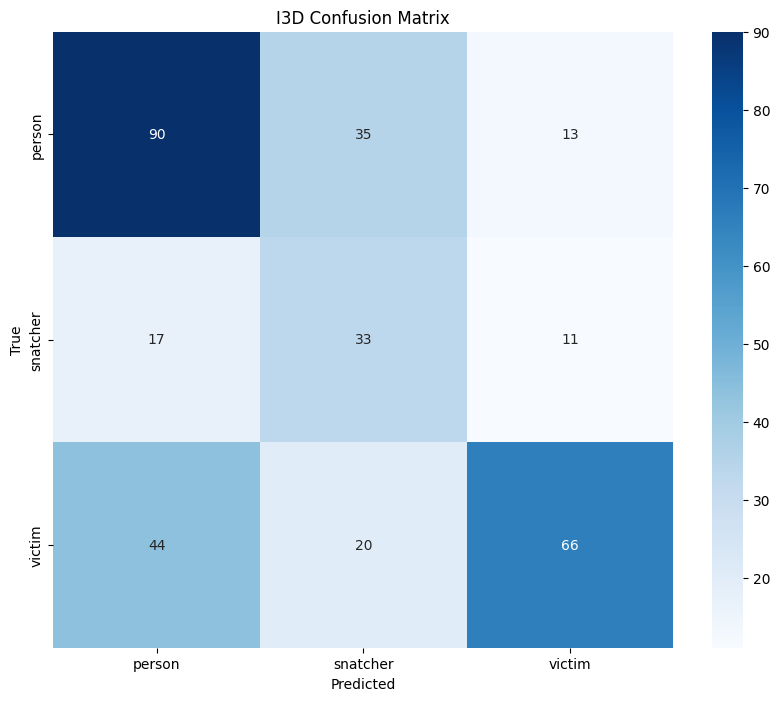

In [17]:
import sys
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
from pytorch_i3d import InceptionI3d

# -------------------------------
# Custom print
# -------------------------------
def custom_print(msg):
    sys.stdout.write(msg + "\n")
    sys.stdout.flush()

# -------------------------------
# Config
# -------------------------------
dataset_path = r"D:\I3D\yashti_test\Merged dataset"  # dataset directory
model_path = r"D:\I3D\MODEL\i3d_finetuned.pt"  # best model saved
batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_print(f"Using device: {device}")

# -------------------------------
# Dataset class
# -------------------------------
class VideoClipDataset(torch.utils.data.Dataset):
    def __init__(self, data_root):
        self.clip_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(data_root))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_names)}
        custom_print(f"📁 Found classes: {self.class_names}")

        for cls in self.class_names:
            folder = os.path.join(data_root, cls)
            for f in os.listdir(folder):
                if f.endswith(".pt"):
                    self.clip_paths.append(os.path.join(folder, f))
                    self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.clip_paths)

    def __getitem__(self, idx):
        clip = torch.load(self.clip_paths[idx], map_location="cpu").float()
        label = self.labels[idx]
        return clip, label

# -------------------------------
# Load dataset and DataLoader
# -------------------------------
dataset = VideoClipDataset(dataset_path)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
num_classes = len(dataset.class_names)
custom_print(f"Total clips: {len(dataset)} | Classes: {num_classes}")

# -------------------------------
# Load model
# -------------------------------
i3d = InceptionI3d(400, in_channels=32)
i3d.replace_logits(num_classes)
i3d.avg_pool = nn.AvgPool3d(kernel_size=(1, 7, 7), stride=1, padding=(0, 0, 0))
i3d = i3d.to(device)

state_dict = torch.load(model_path, map_location=device)
i3d.load_state_dict(state_dict)
i3d.eval()
custom_print(f"Model loaded from {model_path}")
from tqdm import tqdm  # Add this at the top with other imports

# -------------------------------
# Evaluation with progress bar
# -------------------------------
criterion = nn.CrossEntropyLoss()
all_preds, all_labels = [], []
total_loss = 0
num_batches = 0

custom_print("📊 Starting evaluation...")

# Use tqdm for the progress bar
progress_bar = tqdm(loader, desc="Evaluating", ncols=90)
with torch.no_grad():
    for clips, labels in progress_bar:
        clips, labels = clips.to(device), labels.to(device)
        outputs = i3d(clips)
        outputs = outputs.squeeze(-1).squeeze(-1).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        num_batches += 1

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Update progress bar with current batch loss
        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

avg_loss = total_loss / num_batches
accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=dataset.class_names, zero_division=0)
cm = confusion_matrix(all_labels, all_preds)

custom_print("==================================================")
custom_print("✅ Evaluation Complete")
custom_print(f"🚀 Average Loss: {avg_loss:.4f}")
custom_print(f"🚀 Accuracy: {accuracy*100:.2f}%")
custom_print("==================================================")
custom_print("\n📊 Classification Report:\n")
custom_print(report)

# -------------------------------
# Confusion Matrix
# -------------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset.class_names, yticklabels=dataset.class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("I3D Confusion Matrix")

plot_filename = "i3d_confusion_matrix.png"
plt.savefig(plot_filename)
custom_print(f"📈 Confusion matrix saved as {plot_filename}")
